In [1]:
# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import Image, SVG
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

In [2]:
# Filepaths, pandas, numpy, and Tensorflow
import os
import pandas as pd
import numpy as np
import tensorflow as tf

2024-04-11 14:13:25.287673: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

### Keras Specific Dependencies

In [4]:
# Keras
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist

## Loading and Preprocessing our Data

### Load the Skin Cancer Image Dataset and Metadata

Number of images loaded: 10015


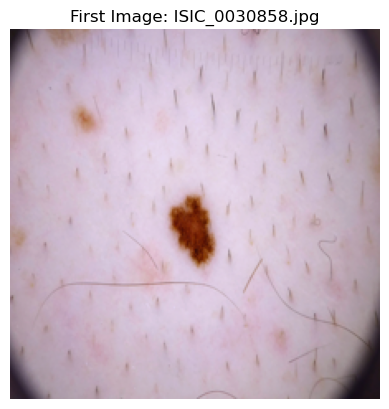

In [5]:
from PIL import Image

# Define folder path where images are stored
folder_path = "Resources/Skin Cancer/Skin Cancer"

# Load images
def load_images_from_folder(folder_path, image_size=(224, 224)):
    """
    Load images from all subfolders of a given folder and resize them to a specified size.
    
    Args:
    - folder_path (str): The path to the folder containing the subfolders.
    - image_size (tuple, optional): The desired size of the images. Defaults to (224, 224).

    
    Returns:
    - images (list): A list of tuples, where each tuple contains a filename and its corresponding, resized image.
    """
    images = []
    # Iterate over all subfolders and their contents
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg"):
                file_path = os.path.join(root, file)
                img = Image.open(file_path)
                if img is not None:
                    img = img.resize(image_size)
                    images.append((file, img))  # Storing filename along with the image
    return images

# Call function to define images
images = load_images_from_folder(folder_path)

# Check that all 10,015 images were loaded
print("Number of images loaded:", len(images))

# Check first image
if images:
    # Extract the first image from the list
    first_filename, first_image = images[0]
    
    # Display the first image
    plt.imshow(first_image)
    plt.title("First Image: " + first_filename)  # Add title with filename
    plt.axis('off')  # Turn off axis
    plt.show()

In [6]:
# Define csv file name
csv_file = "Resources/HAM10000_metadata.csv"

# Load metadata csv
def load_metadata_from_csv(csv_file):
    """
    Load metadata from a CSV file and return it as a DataFrame.
    
    Args:
    - csv_file (str): The path to the CSV file containing the metadata.
    
    Returns:
    - metadata (DataFrame): A DataFrame containing the metadata read from the CSV file.
    """
    metadata = pd.read_csv(csv_file)
    return metadata

# Call function to define metadata
metadata = load_metadata_from_csv(csv_file)

# Preview pandas dataframe to confirm metadata loaded correctly
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
# Match images with metadata based on filenames
def match_images_with_metadata(images, metadata):
    """
    Match images with metadata based on filenames.

    Args:
    - images (list): A list of tuples containing (filename, image).
    - metadata (DataFrame): A DataFrame containing metadata.

    Returns:
    - matched_data (list): A list of tuples containing (filename, image, matched metadata row).
    """
    matched_data = []
    for filename, img in images:
        # Extract the filename without extension
        filename_without_ext = os.path.splitext(filename)[0]
        # Find corresponding row in metadata with matching filename
        matched_row = metadata.loc[metadata['image_id'] == filename_without_ext]
        # If a match is found, store the image and metadata together
        if not matched_row.empty:
            matched_data.append((filename, img, matched_row))
    return matched_data

# Call function to define matched_data
matched_data = match_images_with_metadata(images, metadata)

# Check that all 10,015 images were matched with metadata
print("Number of matched images and metadata:", len(matched_data))

Number of matched images and metadata: 10015


In [8]:
# Create pandas dataframe of matched_data

def create_metadata_image_dataframe(matched_data):
    """
    Create a DataFrame containing metadata with corresponding images.
    
    Args:
    - matched_data (list): A list of tuples containing (filename, image, metadata_row).
    
    Returns:
    - df (DataFrame): A DataFrame where each row corresponds to a matched image and its metadata.
    """
    data = []
    for filename, img, metadata_row in matched_data:
        metadata_dict = metadata_row.to_dict(orient='records')[0]  # Convert metadata row to dictionary
        metadata_dict['Image'] = img  # Add the image to the metadata dictionary
        data.append(metadata_dict)
    df = pd.DataFrame(data)
    return df

# Call function to define metadata_image_df
metadata_image_df = create_metadata_image_dataframe(matched_data)

# Preview dataframe
metadata_image_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Image
0,HAM_0001813,ISIC_0030858,nv,histo,60.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
1,HAM_0002381,ISIC_0030680,nv,follow_up,80.0,male,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
2,HAM_0000268,ISIC_0033389,nv,histo,10.0,female,trunk,<PIL.Image.Image image mode=RGB size=224x224 a...
3,HAM_0003006,ISIC_0032097,nv,follow_up,55.0,male,back,<PIL.Image.Image image mode=RGB size=224x224 a...
4,HAM_0003321,ISIC_0032929,bkl,histo,75.0,female,face,<PIL.Image.Image image mode=RGB size=224x224 a...
